In [16]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import geopandas
import shapely
import cmocean
import pandas
import joblib

In [6]:
#filename = '/Users/baird/Dropbox/_data_observations/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4-10.2018-05-31T17-55-21ZN.hdf'
file_dir = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/'

In [7]:
file_list = sorted(glob.glob(file_dir+'/*.hdf'))

In [8]:
# ===== open file, pull out specific data set
gdal_file = gdal.Open(file_list[0])
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter

In [9]:
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_tbc_data = gdal_tbc_ds.ReadAsArray()

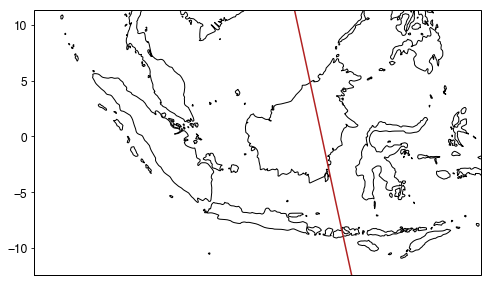

In [10]:
ds = xarray.open_dataset(file_list[0])

lat = ds['Latitude'].values[:,0]
lon = ds['Longitude'].values[:,0]


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

plot multiple at once

# open states

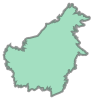

In [11]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union
borneo_main_geom = borneo_gdf_union.geoms[15]
list(borneo_gdf_union.geoms)[15]

In [15]:
track_geom_list = []
file_intersect_list = []

for f in range(20):#file_list.__len__()):
    if f%100==0:
        print(f+1, 'out of '+str(file_list.__len__()))
    #print(file)
    ds = xarray.open_dataset(file_list[f])
    lat = ds['Latitude'].isel(fakeDim3=0).values
    lon = ds['Longitude'].isel(fakeDim5=0).values
    ds.close()
    
    track_geom_temporary = shapely.geometry.LineString(zip(lon,lat))
    if track_geom_temporary.intersects(borneo_main_geom):
        track_geom_list.append(track_geom_temporary)
        file_intersect_list.append(file_list[f])

file_intersect_list = numpy.array(file_intersect_list)
numpy.save('borneo_land_mass_intersections.npy', file_intersect_list)

1 out of 11427


In [17]:
# define function to search whether the paths intersect
# faster to have borneo_main_geom already defined

geometry_of_interest = borneo_main_geom
def do_they_intersect(file):
    file_intersect_list = []
    track_geom_list = []
    
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].isel(fakeDim3=0).values
    lon = ds['Longitude'].isel(fakeDim5=0).values
    ds.close()
    
    track_geom = shapely.geometry.LineString(zip(lon,lat))
    if track_geom.intersects(geometry_of_interest):
        #track_geom_list.append(track_geom_temporary)
        file_intersect_list.append(file)
        
    return file_intersect_list#, track_geom_list

    Timing stats (first 50 files)
    n_jobs = 4:  8.4 s
    n_jobs = 8:  15.4 s
    n_jobs = 10:  11.7s

    Timing stats (first 100 files)
    n_jobs = 2:  18.3 s
    n_jobs = 3:  16.9 s
    n_jobs = 4:  16.6 s
    n_jobs = 5:  18.1 s
    n_jobs = 8:  30.8 s
    n_jobs = 10:  27.2 s
    n_jobs = 32:  51.4 s
    n_jbos = 64 (n_jobs=-1):  23.5 s

In [24]:
joblib_result = joblib.Parallel(n_jobs=4, verbose=10)(joblib.delayed(do_they_intersect)(f) for f in file_list)

flatten_result = numpy.array([item for sublist in joblib_result for item in sublist])
numpy.save('borneo_land_mass_intersection_files_ALL.npy', flatten_result)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   36.0s
[Parallel(

[Parallel(n_jobs=4)]: Done 9377 tasks      | elapsed: 54.1min
[Parallel(n_jobs=4)]: Done 9514 tasks      | elapsed: 54.9min
[Parallel(n_jobs=4)]: Done 9653 tasks      | elapsed: 55.7min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 56.5min
[Parallel(n_jobs=4)]: Done 9933 tasks      | elapsed: 57.4min
[Parallel(n_jobs=4)]: Done 10074 tasks      | elapsed: 58.3min
[Parallel(n_jobs=4)]: Done 10217 tasks      | elapsed: 59.2min
[Parallel(n_jobs=4)]: Done 10360 tasks      | elapsed: 60.1min
[Parallel(n_jobs=4)]: Done 10505 tasks      | elapsed: 61.1min
[Parallel(n_jobs=4)]: Done 10650 tasks      | elapsed: 62.1min
[Parallel(n_jobs=4)]: Done 10797 tasks      | elapsed: 63.0min
[Parallel(n_jobs=4)]: Done 10944 tasks      | elapsed: 63.9min
[Parallel(n_jobs=4)]: Done 11093 tasks      | elapsed: 64.8min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 65.7min
[Parallel(n_jobs=4)]: Done 11393 tasks      | elapsed: 66.6min
[Parallel(n_jobs=4)]: Done 11427 out of 11427 | elapsed: 66.

In [25]:
flatten_result.size

3591